In [1]:
import jax.numpy as jnp
import numpy as np
import os
from jax import jit
from functools import partial
import matplotlib.pyplot as plt

import appletree as apt
from appletree import flex
from appletree import ipm
from appletree import imm
from appletree.flex import randgen
from appletree.flex.plugin import *

In [2]:
apt.utils.set_gpu_memory_usage(0.2)
par_manager = ipm.ParManager('./appletree/ipm/par_config/par_config.json')
map_manager = imm.MapManager()

In [3]:
par_manager.sample_init()
par_manager.get_all_parameter()

{'w': 0.01367683956485041,
 'fano': 0.059,
 'gas_gain': 31.3,
 'drift_velocity': 0.0677,
 's2_threshold': 500.0,
 'field': 23.0,
 'nex_ni_ratio': 0.09761039796567074,
 'g1': 0.14936256191348876,
 'g2': 16.534883144466033,
 'p_dpe': 0.2279294433212318,
 'py0': 0.12037037993026961,
 'py1': 43.305951633132366,
 'py2': -0.35871268626903074,
 'py3': 0.6407261936793427,
 'py4': 0.7099426185023536,
 'rf0': 0.02232658606391688,
 'rf1': 0.10191119770839283}

In [4]:
map_manager.register_json_map(os.path.join(imm.MAPPATH, 's1_correction_map_regbin.json'), coord_type='regbin', map_name='s1_lce')
map_manager.register_json_map(os.path.join(imm.MAPPATH, 's2_correction_map_regbin.json'), coord_type='regbin', map_name='s2_lce')
map_manager.register_json_map(os.path.join(imm.MAPPATH, 'elife.json'), coord_type='point', map_name='elife')
map_manager.register_json_map(os.path.join(imm.MAPPATH, 's1_bias.json'), coord_type='point', map_name='s1_bias')
map_manager.register_json_map(os.path.join(imm.MAPPATH, 's1_smearing.json'), coord_type='point', map_name='s1_smear')
map_manager.register_json_map(os.path.join(imm.MAPPATH, 's2_bias.json'), coord_type='point', map_name='s2_bias')
map_manager.register_json_map(os.path.join(imm.MAPPATH, 's2_smearing.json'), coord_type='point', map_name='s2_smear')
map_manager.register_json_map(os.path.join(imm.MAPPATH, '3fold_recon_eff.json'), coord_type='point', map_name='s1_eff')

In [5]:
map_manager.registration

{'s1_lce': '/home/zihaoxu/appletree/appletree/imm/map/s1_correction_map_regbin.json',
 's2_lce': '/home/zihaoxu/appletree/appletree/imm/map/s2_correction_map_regbin.json',
 'elife': '/home/zihaoxu/appletree/appletree/imm/map/elife.json',
 's1_bias': '/home/zihaoxu/appletree/appletree/imm/map/s1_bias.json',
 's1_smear': '/home/zihaoxu/appletree/appletree/imm/map/s1_smearing.json',
 's2_bias': '/home/zihaoxu/appletree/appletree/imm/map/s2_bias.json',
 's2_smear': '/home/zihaoxu/appletree/appletree/imm/map/s2_smearing.json',
 's1_eff': '/home/zihaoxu/appletree/appletree/imm/map/3fold_recon_eff.json'}

In [6]:
args = (par_manager, map_manager)

#### Microphysics plugins

In [7]:
plugin1 = EnergySpectra(*args)
plugin2 = Quenching(*args)
plugin3 = Ionization(*args)
plugin4 = mTI(*args)
plugin5 = RecombFluct(*args)
plugin6 = TrueRecomb(*args)
plugin7 = Recombination(*args)

#### Detector plugins

In [8]:
plugin8 = PositionSpectra(*args)
plugin9 = S1Correction(*args)
plugin10 = S2Correction(*args)
plugin11 = PhotonDetection(*args)
plugin12 = S1PE(*args)
plugin13 = DriftLoss(*args)
plugin14 = ElectronDrifted(*args)
plugin15 = S2PE(*args)

#### Reconstruction plugins

In [9]:
plugin16 = S1(*args)
plugin17 = S2(*args)
plugin18 = cS1(*args)
plugin19 = cS2(*args)

#### Efficiency plugins

In [10]:
plugin20 = S2Threshold(*args)
plugin21 = S1ReconEff(*args)

# Get binning

In [11]:
import pandas as pd
data = pd.read_csv('./appletree/bbf/data/data_XENONnT_Rn220_v8_strax_v1.2.2_straxen_v1.7.1_cutax_v1.9.0.csv')
x_bins, y_bins = apt.utils.get_equiprob_bins_2d(
    data[['cs1', 'cs2']].to_numpy(),
    [15, 15],
    order=[0, 1],
    x_clip=[0, 100],
    y_clip=[1e2, 1e4]
)

# Pipeline

In [12]:
@apt.utils.timeit
@partial(jit, static_argnums=(1, ))
def sim(key, n):
    key, energy = plugin1(key, n)
    key, n_q = plugin2(key, energy)
    key, n_i = plugin3(key, n_q)
    key, r_mean = plugin4(key, energy)
    key, r_std = plugin5(key, energy)
    key, r = plugin6(key, r_mean, r_std)
    key, n_ph, n_e = plugin7(key, n_q, n_i, r)
    
    key, x, y, z = plugin8(key, n)
    key, s1_correction = plugin9(key, x, y, z)
    key, s2_correction = plugin10(key, x, y)
    key, n_s1_phd = plugin11(key, n_ph, s1_correction)
    key, n_s1_pe = plugin12(key, n_s1_phd)
    key, surv_prob = plugin13(key, z)
    key, n_e_drifted = plugin14(key, n_e, surv_prob)
    key, n_s2_pe = plugin15(key, n_e_drifted, s2_correction)
    
    key, s1 = plugin16(key, n_s1_phd, n_s1_pe)
    key, s2 = plugin17(key, n_s2_pe)
    key, cs1 = plugin18(key, s1, s1_correction)
    key, cs2 = plugin19(key, s2, s2_correction, surv_prob)
    
    key, acc_s2_threshold = plugin20(key, s2)
    key, acc_s1_recon_eff = plugin21(key, n_s1_phd)
    
    eff = acc_s2_threshold*acc_s1_recon_eff
    
    hist = flex.hist.make_hist_irreg_bin_2d(
        jnp.asarray([cs1, cs2]).T,
        x_bins, y_bins, weights=eff
    )
    
    return key, hist

In [13]:
batch_size = int(1e6)
key = flex.randgen.get_key()

#### Build

In [14]:
key, hist = sim(key, batch_size)

 Function <sim> starts. 
 Function <sim> ends! Time cost = 4765.867233 msec. 


(500.0, 10000.0)

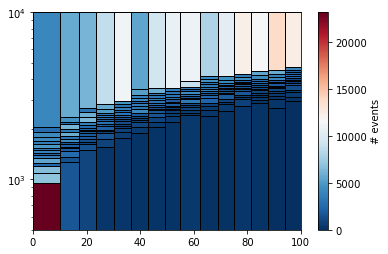

In [15]:
apt.utils.plot_irreg_histogram_2d(x_bins, y_bins, hist, density=False)
plt.yscale('log')
plt.ylim(5e2, 1e4)

#### Speed test

In [16]:
@apt.utils.timeit
def benchmark():
    key = randgen.get_key()
    for itr in range(100):
        key, _ = sim(key, int(1e6))

In [17]:
benchmark()

 Function <benchmark> starts. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 1.414537 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 1.128435 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 8.047342 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 15.865803 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 18.839836 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 13.344288 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 17.819166 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 13.812542 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 13.914824 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 17.560244 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 17.631531 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 17.771244 msec. 
 Function <sim> starts. 
 Function <sim> ends! Time cost = 1